In [1]:
# ============================================================
# 03. Geoestadística - Cerrillos
# ============================================================

# 1. Importar librerías
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from skgstat import Variogram, models
from pykrige.ok import OrdinaryKriging

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [2]:
# ============================================================
# 2. Cargar datasets
# ============================================================
RAW_DIR = "../data/raw"

# Límite comunal
cerrillos = gpd.read_file(f"{RAW_DIR}/cerrillos_limite.shp").to_crs(epsg=32719)

# Edificios
buildings = gpd.read_file(f"{RAW_DIR}/osm_buildings_cerrillos.geojson").to_crs(epsg=32719)

# Calcular áreas
buildings["area_m2"] = buildings.geometry.area

print(" Datos cargados para Geoestadística")
print(f"Edificios en Cerrillos: {len(buildings)}")

# Usar centroides como puntos de muestreo
buildings["centroid"] = buildings.geometry.centroid
coords = np.array(list(zip(buildings.centroid.x, buildings.centroid.y)))
values = buildings["area_m2"].values


 Datos cargados para Geoestadística
Edificios en Cerrillos: 4016


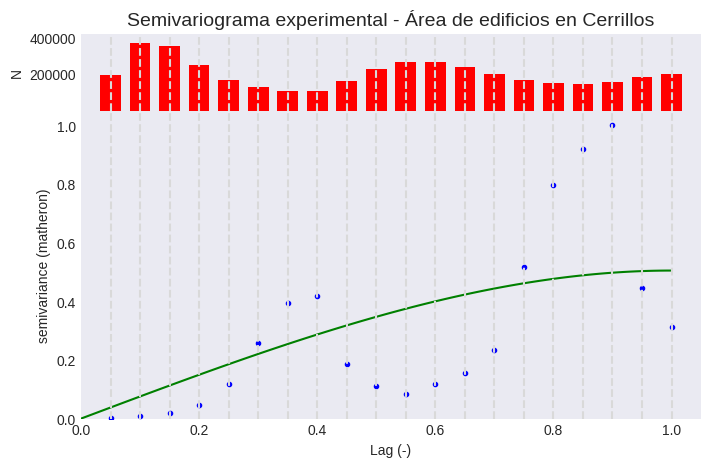

 Parámetros del semivariograma
Modelo: spherical
Nugget: 2286.75, Sill: 6318472.07, Range: 0.00


In [3]:
# ============================================================
# 3. Semivariograma experimental
# ============================================================
V = Variogram(coords, values, normalize=True, n_lags=20, maxlag="median")

fig = V.plot()
plt.title("Semivariograma experimental - Área de edificios en Cerrillos", fontsize=14)
plt.show()

print(" Parámetros del semivariograma")
print(f"Modelo: {V.model.__name__}")
print(f"Nugget: {V.parameters[0]:.2f}, Sill: {V.parameters[1]:.2f}, Range: {V.parameters[2]:.2f}")

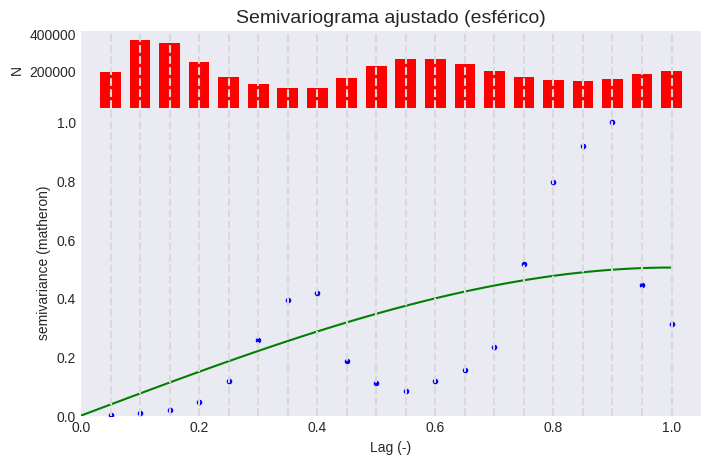

In [5]:
# ============================================================
# 4. Ajuste de modelo teórico (ej: esférico)
# ============================================================
V.model = "spherical"
fig = V.plot()
plt.title("Semivariograma ajustado (esférico)", fontsize=14)
plt.show()

In [4]:
# ============================================================
# 5. Kriging ordinario
# ============================================================
# Crear grilla de interpolación dentro del polígono comunal
xmin, ymin, xmax, ymax = cerrillos.total_bounds
gridx = np.linspace(xmin, xmax, 100)
gridy = np.linspace(ymin, ymax, 100)

OK = OrdinaryKriging(
    coords[:,0], coords[:,1], values,
    variogram_model="spherical",
    verbose=False, enable_plotting=False
)

z, ss = OK.execute("grid", gridx, gridy)

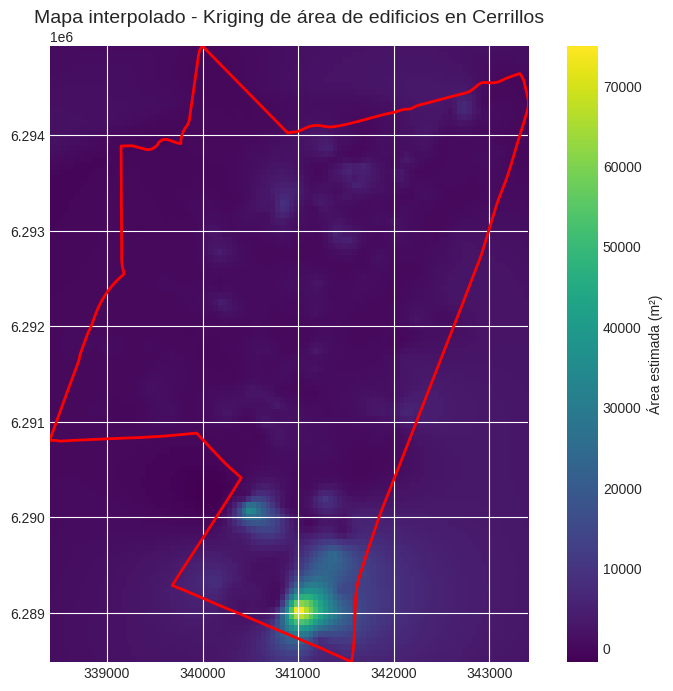

In [6]:
# ============================================================
# 6. Visualización de kriging
# ============================================================
fig, ax = plt.subplots(figsize=(10,8))
c = ax.imshow(
    z,
    extent=(xmin, xmax, ymin, ymax),
    origin="lower",
    cmap="viridis"
)
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
fig.colorbar(c, ax=ax, label="Área estimada (m²)")
ax.set_title("Mapa interpolado - Kriging de área de edificios en Cerrillos", fontsize=14)
plt.show()

In [7]:
# ============================================================
# 7. Validación cruzada simple 
# ============================================================
import numpy as np
from pykrige.ok import OrdinaryKriging
from tqdm import tqdm

# Tomar solo 20% de los puntos
n = len(coords)
idx_val = np.random.choice(n, size=int(0.2*n), replace=False)

predicciones = []
observados = []

for i in tqdm(idx_val, desc="Validación cruzada (20%)"):
    coords_train = np.delete(coords, i, axis=0)
    values_train = np.delete(values, i)

    OK_cv = OrdinaryKriging(
        coords_train[:,0], coords_train[:,1], values_train,
        variogram_model="spherical",
        verbose=False, enable_plotting=False
    )

    z_cv, _ = OK_cv.execute("points", [coords[i,0]], [coords[i,1]])
    predicciones.append(z_cv[0])
    observados.append(values[i])

# Calcular RMSE
errors = np.array(predicciones) - np.array(observados)
rmse = np.sqrt(np.mean(errors**2))
print(f"\nValidación Cruzada (20% de datos) - RMSE: {rmse:.2f}")


Validación cruzada (20%): 100%|██████████| 803/803 [31:46<00:00,  2.37s/it]


Validación Cruzada (20% de datos) - RMSE: 2296.04


In [8]:
# ============================================================
# 🔹 GUARDAR RESULTADOS DE GEOESTADÍSTICA
# ============================================================

from pathlib import Path
import json
import matplotlib.pyplot as plt

OUTPUT_DIR = Path("../outputs/reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1. Guardar semivariograma ---
fig = V.plot()
plt.title("Semivariograma experimental - Área de edificios en Cerrillos")
plt.xlabel("Distancia (m)")
plt.ylabel("Semivarianza")
plt.savefig(OUTPUT_DIR / "geo_semivariograma.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Semivariograma guardado en outputs/reports/geo_semivariograma.png")

# --- 2. Guardar mapa interpolado (Kriging) ---
fig, ax = plt.subplots(figsize=(10,8))
c = ax.imshow(
    z, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis"
)
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
fig.colorbar(c, ax=ax, label="Área estimada (m²)")
ax.set_title("Mapa interpolado - Kriging del área de edificios en Cerrillos")
plt.savefig(OUTPUT_DIR / "geo_kriging_map.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Mapa de Kriging guardado en outputs/reports/geo_kriging_map.png")

# --- 3. Guardar resultados de validación cruzada ---
validation_results = {
    "rmse": float(rmse),
    "n_validados": int(len(observados))
}

with open(OUTPUT_DIR / "geo_validation.json", "w") as f:
    json.dump(validation_results, f, indent=4)

print(f"✅ Resultados de validación guardados en outputs/reports/geo_validation.json (RMSE={rmse:.2f})")


✅ Semivariograma guardado en outputs/reports/geo_semivariograma.png
✅ Mapa de Kriging guardado en outputs/reports/geo_kriging_map.png
✅ Resultados de validación guardados en outputs/reports/geo_validation.json (RMSE=2296.04)
